This notebook contains all code necessary for reproducing the results and plots.

**To successfully run this code, you must:**
   - Set output_directory_path in the Setup cell
   - Ensure that all packages imported in the Setup cell are installed on your machine
   - Ensure that [aegis-sim 2.1](https://pypi.org/project/aegis-sim/2.1/) is installed on your machine 

**The code below consists of four parts:**
   
   0. _Setup_. This part lists all required packages for import and the output directory path
   1. _Generate configuration files_. In this step, we generate input for the simulation.
   2. _Run simulations_. In this step, we let AEGIS run and feed it the generated input.
   3. _Analyze results_. In this step, we analyze and visualize AEGIS output.

# 0. Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import helpfuncs

In [3]:
from aegis.help.container import Container

cont = Container("../experiments/1114/pos-300-sexual-30")

In [4]:
%load_ext lab_black

# Adjust this for your machine
output_directory_path = "../experiments/1114"  # Directory for saving results
plot_directory_path = "preprint-temp"  # Directory for saving plots

# Imports
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import tqdm
import pathlib
import yaml
import itertools
import pickle

# Customization
matplotlib.rcParams.update({"font.size": 6})
plt.rcParams.update({"font.sans-serif": "Arial"})

# 1. Generate configuration files

Each configuration file consists of constant and variable paramaters. Constant parameters are equal across all simulations, variable parameters are not. We are interested in the effect of variable parameters on the evolution of life history. Variable parameters are:
  - `MAX_POPULATION_SIZE`
  - `REPRODUCTION_MODE`
  - `PHENOMAP_SPECS`. This is used to encode two kinds of mutational effects: detrimental monotropic (theory of mutation accumulation) or antagonistic pleiotropic (theory of antagonistic pleiotropy).

### Setup-specific parameters

In [5]:
path_dir = pathlib.Path(output_directory_path)
path_dir.mkdir(exist_ok=True)  # Create the directory if it does not exist

plots_dir = pathlib.Path(plot_directory_path)
plots_dir.mkdir(exist_ok=True)  # Create the directory if it does not exist

### Constant parameters

In [6]:
params_const = {
    # General
    "STAGES_PER_SIMULATION_": 10000000,
    "RANDOM_SEED_": 42,
    #
    # Life history
    "MATURATION_AGE": 10,
    "MAX_LIFESPAN": 50,
    #
    # Genome structure
    "BITS_PER_LOCUS": 1,
    "G_neut_evolvable": True,
    "G_neut_lo": 0,
    "G_neut_hi": 1,
    "G_neut_initial": 0,
    "G_neut_interpreter": "single_bit",
    "G_repr_interpreter": "const1",
    "G_surv_interpreter": "const1",
    "G_repr_hi": 0.3,  # reproduction rate
    "G_neut_agespecific": 2500,  # number of mutating loci
    "G_muta_initial": 0.00001,  # mutation rate
    "MUTATION_RATIO": 100,
    #
    # Recording
    "PICKLE_RATE_": 100000,
    "POPGENSTATS_RATE_": 0,
    "SNAPSHOT_RATE_": 100000,
    "VISOR_RATE_": 1000,
}

### Variable parameters

In [7]:
MAX_POPULATION_SIZEs = (300, 600)  # 300, 3000, 30000
REPRODUCTION_MODEs = ("asexual_diploid",)  # ("sexual", "asexual_diploid")
aging_theories = (
    "pos",
    "MA",
)  # "MA", "AP",

In [8]:
def get_phenomap_specs(RANDOM_SEED_):
    """Generate MA and AP PHENOMAP_SPECS.
    MA specs are equivalent to AP specs but without the beneficial effects."""

    # Random number generator
    rng = np.random.default_rng(RANDOM_SEED_)

    # Number of mutable loci
    N = params_const["G_neut_agespecific"]

    # Set initial survival rate to 0.95
    bckg_specs = []
    for i in range(1, params_const["MAX_LIFESPAN"] + 1):
        bckg_specs.append(["surv", i, "surv", str(i), str(0.95)])

    # Generate N magnitudes of effects
    magns = rng.exponential(1, size=N) * 0.0014

    # Generate N ages at which the effects act
    # Note that it is possible that tn=tn=1
    timings_n = rng.integers(1, params_const["MAX_LIFESPAN"], size=N, endpoint=True)
    timings_p = rng.integers(1, timings_n, size=N, endpoint=True)

    # Assemble magnitudes and timings into specifications
    ma_specs = []
    ap_specs = []
    pos_specs = []

    neut_i = 1
    for m, tp, tn in zip(magns, timings_p, timings_n):
        ap_specs.append(["neut", neut_i, "surv", str(tp), str(m)])
        ap_specs.append(["neut", neut_i, "surv", str(tn), str(-m)])
        neut_i += 1

    neut_i = 1
    for m, tn in zip(magns, timings_n):
        ma_specs.append(["neut", neut_i, "surv", str(tn), str(-m)])
        neut_i += 1

    neut_i = 1
    # Use negative timings because it is uniformly distributed
    for m, tn in zip(magns, timings_n):
        pos_specs.append(["neut", neut_i, "surv", str(tn), str(m)])
        neut_i += 1

    return {
        "MA": ma_specs + bckg_specs,
        "AP": ap_specs + bckg_specs,
        "pos": pos_specs + bckg_specs,
    }


n_specs_studied = 30  # Number of unique phenomaps to generate and simulate
PHENOMAP_SPECS_list = [get_phenomap_specs(seed) for seed in range(n_specs_studied)]

In [9]:
# _ = pd.DataFrame(PHENOMAP_SPECS_list[0][0])
# _["m"] = _[4].astype(float)
# _[_[0] == "neut"].groupby(3).sum("m")
# # _.groupby(3).sum("m")

### Write config files

In [209]:
# Calculate total number of experiments
tqdm_total = (
    len(PHENOMAP_SPECS_list)
    * len(aging_theories)
    * len(REPRODUCTION_MODEs)
    * len(MAX_POPULATION_SIZEs)
)
print(f"Total {tqdm_total} experiments.")

params = itertools.product(
    range(len(PHENOMAP_SPECS_list)),
    aging_theories,
    REPRODUCTION_MODEs,
    MAX_POPULATION_SIZEs,
)

Total 120 experiments.


In [210]:
# Load paths to all existing yml files in the path_dir
yml_paths = [path.with_suffix(".yml") for path in path_dir.glob("*") if path.is_dir()]

# Check if files already exist to prevent overwriting
if yml_paths:
    print("Aborting. There are files in this directory already.")
else:
    print("Writing configuration files.")

    with tqdm.tqdm(total=tqdm_total) as pbar:

        # Iterate over combinations of variable input parameters
        for i, [
            phenomap_i,
            aging_theory,
            REPRODUCTION_MODE,
            MAX_POPULATION_SIZE,
        ] in enumerate(params):

            PHENOMAP_SPECS = PHENOMAP_SPECS_list[phenomap_i][aging_theory]

            # Construct final dictionary containing parameter keys and values
            params_final = params_const.copy()
            params_final["MAX_POPULATION_SIZE"] = MAX_POPULATION_SIZE
            params_final["REPRODUCTION_MODE"] = REPRODUCTION_MODE
            params_final["RECOMBINATION_RATE"] = (
                0.5 if REPRODUCTION_MODE == "sexual" else 0
            )
            params_final["PHENOMAP_SPECS"] = PHENOMAP_SPECS

            # The ratio of 0->1 vs 1->0 is inverted for when simulation scenario is positive mutations
            if aging_theory == "pos":
                params_final["MUTATION_RATIO"] = 1 / params_const["MUTATION_RATIO"]

            # Write the yml to output directory
            yml_path = (
                path_dir
                / f"{aging_theory}-{MAX_POPULATION_SIZE}-{REPRODUCTION_MODE}-{i}.yml"
            )

            with open(yml_path, "w") as file_:
                yaml.dump(params_final, file_, sort_keys=False, default_flow_style=True)

            # Update the progress bar
            pbar.update(1)

Writing configuration files.


100%|██████████| 120/120 [00:47<00:00,  2.52it/s]


# 2. Run simulations
To run the simulations using the generated configuration files, you must run the commands below in a terminal. These can be distributed on a computational cluster. It is advisable to run them in a virtual environment in which aegis-sim v2.1 is installed.

In [212]:
# Load paths to all existing yml files in the path_dir
yml_paths = [path for path in path_dir.glob("*") if path.suffix == ".yml"]

for yml_path in yml_paths:
    message = f"qsub -N pub /wins/vlzno/projects/NeMAAP/sge_merlin.sh /wins/vlzno/projects/NeMAAP/experiments/{path_dir.name}/{yml_path.name}"  # EGO
    # message = f"python3 -m aegis {yml_path}"
    print(message)

qsub -N pub /wins/vlzno/projects/NeMAAP/sge_merlin.sh /wins/vlzno/projects/NeMAAP/experiments/1115/MA-300-asexual_diploid-54.yml
qsub -N pub /wins/vlzno/projects/NeMAAP/sge_merlin.sh /wins/vlzno/projects/NeMAAP/experiments/1115/pos-300-asexual_diploid-96.yml
qsub -N pub /wins/vlzno/projects/NeMAAP/sge_merlin.sh /wins/vlzno/projects/NeMAAP/experiments/1115/MA-600-asexual_diploid-115.yml
qsub -N pub /wins/vlzno/projects/NeMAAP/sge_merlin.sh /wins/vlzno/projects/NeMAAP/experiments/1115/pos-600-asexual_diploid-101.yml
qsub -N pub /wins/vlzno/projects/NeMAAP/sge_merlin.sh /wins/vlzno/projects/NeMAAP/experiments/1115/pos-600-asexual_diploid-37.yml
qsub -N pub /wins/vlzno/projects/NeMAAP/sge_merlin.sh /wins/vlzno/projects/NeMAAP/experiments/1115/MA-300-asexual_diploid-94.yml
qsub -N pub /wins/vlzno/projects/NeMAAP/sge_merlin.sh /wins/vlzno/projects/NeMAAP/experiments/1115/pos-600-asexual_diploid-97.yml
qsub -N pub /wins/vlzno/projects/NeMAAP/sge_merlin.sh /wins/vlzno/projects/NeMAAP/experimen

# 3. Analyze results

### Loading results

In [117]:
output_directory_paths = [
    "../experiments/0815",
    "../experiments/0830",
    # "../experiments/1114",
]

In [118]:
# Load paths to all experiment folders
paths_dir = [
    pathlib.Path(output_directory_path)
    for output_directory_path in output_directory_paths
]
yml_paths = [
    path.with_suffix(".yml")
    for path_dir in paths_dir
    for path in path_dir.glob("*")
    if path.is_file()
]

In [7]:
counts = [path.parent.name for path in yml_paths]
len([c for c in counts if c == "0815"]), len([c for c in counts if c == "0830"]), len(
    [c for c in counts if c == "1114"]
)

(240, 120, 0)

In [8]:
# import multiprocessing as mp

# def readcsv(path):
#     return pd.read_csv(path, usecols=range(50))

# p_paths = [yml_path.with_suffix("") / "0/visor/phenotypes.csv" for yml_path in yml_paths]

# with mp.Pool(10) as p:
#     csvs = p.map(readcsv, p_paths)

In [30]:
# cont = Container(yml_paths[0].with_suffix(""))
# cont

# cont = Container("../experiments/1114/pos-300-sexual-30")

In [31]:
RESULTS = {}

for i, yml_path in tqdm.tqdm(enumerate(yml_paths), total=len(yml_paths)):

    # Path to .csv file with phenotypes
    path = yml_path.with_suffix("") / "0/visor/phenotypes.csv"
    phenokind, popsize, reprmode, i = yml_path.stem.split("-")

    # # Read configuration
    # with open(yml_path, "r") as file_:
    #     config = yaml.safe_load(file_)
    # popsize = config["MAX_POPULATION_SIZE"]
    # reprmode = config["REPRODUCTION_MODE"]

    # Read in the intrinsic survival rates
    pheno = pd.read_csv(path, usecols=range(50))
    # print(len(pheno))
    # if len(pheno) < 100:
    #     print([phenokind, popsize, reprmode])
    #     continue

    # Only look at the last evolved rates
    pheno = pheno.iloc[-1]

    # Save RESULTS
    RESULTS[(phenokind, popsize, reprmode, i)] = pheno

100%|██████████| 180/180 [00:07<00:00, 25.46it/s]


In [47]:
GENOS = {}

for i, yml_path in tqdm.tqdm(enumerate(yml_paths), total=len(yml_paths)):

    # Path to .csv file with phenotypes
    path = yml_path.with_suffix("") / "0/visor/genotypes.csv"
    phenokind, popsize, reprmode, i = yml_path.stem.split("-")

    # # Read configuration
    # with open(yml_path, "r") as file_:
    #     config = yaml.safe_load(file_)
    # popsize = config["MAX_POPULATION_SIZE"]
    # reprmode = config["REPRODUCTION_MODE"]

    # Read in the intrinsic survival rates
    pheno = pd.read_csv(path, usecols=range(50))
    # print(len(pheno))
    if len(pheno) < 51:
        print([len(pheno), phenokind, popsize, reprmode])
        continue

    # Only look at the last evolved rates
    pheno = pheno.iloc[50]

    # Save RESULTS
    RESULTS[(phenokind, popsize, reprmode, i)] = pheno

100%|██████████| 180/180 [00:07<00:00, 24.58it/s]


# Plotting

In [48]:
format_ = "png"
savefig_settings = {"dpi": 300}
matplotlib.rcParams.update({"font.size": 8})
# import matplotlib.font_manager
# plt.rcParams["font.family"] = "Arial"

# Transform data into a table

df = pd.DataFrame(RESULTS).T.sort_index().droplevel(3, axis=0)
n_specs_studied = int(len(df) / len(df.index.unique()))

figsize = (2, 2)
dpi = 300

colors = ["crimson", "forestgreen", "dodgerblue"]
plot_colors = [color for color in colors for _ in range(n_specs_studied)]

patches = [
    mpatches.Circle(xy=(0, 0), color=colors[0], label="300"),
    mpatches.Circle(xy=(0, 0), color=colors[1], label="3000"),
    mpatches.Circle(xy=(0, 0), color=colors[2], label="30000"),
]

## Plot mortality

In [33]:
# df1115 = df

In [35]:
# (df1115 - 0.95).reset_index().groupby(["level_0", "level_1", "level_2"]).mean().T.plot(
#     figsize=(8, 4)
# )

In [36]:
# (df).reset_index().groupby(["level_0", "level_1", "level_2"]).mean().T.plot(
#     figsize=(8, 4)
# )

In [37]:
# df.reset_index().groupby(["level_1", "level_2"]).sum(0).drop("level_0", axis=1).T.plot()
# plt.show()

# _ = df.reset_index().groupby(["level_1", "level_2"]).sum(0).drop("level_0", axis=1)

# _.cumsum(1).diff(periods=9, axis=1).iloc[:, 9::10].div(9 * 30).add(-0.95).T.plot()

In [38]:
# (df.xs(("pos", "300", "sexual")) - 0.95).sum(0).plot()

In [40]:
# df = pd.DataFrame(RESULTS).T.sort_index().droplevel(3, axis=0)
# (df - 0.95).reset_index().groupby(["level_0", "level_1", "level_2"]).mean().T.plot(
#     figsize=(8, 4)
# )

In [41]:
# ax_set_styles_general = dict(
#     xlim=[0, 49],
#     xticks=[0, 10, 49],
#     xticklabels=[0, "", 50],
#     facecolor="white",
# )

In [32]:
# RESULTS_2 = RESULTS

In [42]:
# # RESULTS = RESULTS_

# df_ = pd.DataFrame(RESULTS_).T.sort_index().droplevel(3, axis=0)
# df_2 = pd.DataFrame(RESULTS_2).T.sort_index().droplevel(3, axis=0)

In [43]:
# (df_ - 0.95).reset_index().groupby(["level_0", "level_1", "level_2"]).mean().T.plot(
#     figsize=(8, 4)
# )

In [44]:
# (df_2 - 0.95).reset_index().groupby(["level_0", "level_1", "level_2"]).mean().T.plot(
#     figsize=(8, 4)
# )

In [45]:
# (df - 0.95).xs(("pos", "300"), level=[0, 1], axis=0).reset_index().groupby(
#     "index"
# ).sum().T.plot()

In [49]:
ax_set_styles_general = dict(
    xlim=[0, 49],
    xticks=[0, 10, 49],
    xticklabels=[0, "", 50],
    facecolor="white",
)

ax_set_styles_mort = dict(
    ylim=[0, 0.105],
    yticks=[0, 0.05, 0.1],
    yticklabels=[0, 0.05, 0.1],
)

ax_set_styles_surv = dict(
    ylim=[0, 1.01],
)


def plot_lh(df, aging_theory, repr_mode, ax, lw, plot_bckg=False, plot_surv=False):

    # plot lines
    ax.vlines(10, 0, 1, color="magenta", ls="dotted", alpha=0.5, lw=lw)
    if plot_surv:
        default_survivorship = 0.95 ** np.arange(51)
        ax.plot(default_survivorship, color="gray", ls="dotted", lw=lw)
    else:
        ax.hlines(0.05, 0, 51, color="gray", ls="dotted", lw=0.5)

    # calculate data to plot
    if plot_surv:
        data = df.cumprod(1).loc[aging_theory, :, repr_mode].copy()
        data.insert(0, "newcol", [1] * len(data), allow_duplicates=True)
        data = data.T.reset_index(drop=True).T
    else:
        data = (1 - df).loc[aging_theory, :, repr_mode]

    # plot background curves
    if plot_bckg:
        data.T.plot(
            legend=False,
            color=plot_colors,
            ax=ax,
            alpha=0.1,
            lw=lw,
        )

    # plot mean curve
    data.reset_index().groupby("index").mean(0).T.plot(
        ax=ax,
        color=colors,
        lw=lw,
    )

    # ax.legend(
    #     handles=patches,
    #     frameon=False,
    #     # prop={"size": 4},
    #     loc=[0.7, 0.015],
    # )

    ax_set_styles = ax_set_styles_surv if plot_surv else ax_set_styles_mort
    ax.set(**ax_set_styles_general, **ax_set_styles)
    ax.spines[["right", "top"]].set_visible(False)
    ax.get_legend().remove()


# aging_theories = ["MA", "AP", "pos"]
# for mortorsurv in ["mort", "surv"]:
#     for aging_theory in aging_theories:
#         fig, ax = plt.subplots(figsize=figsize, facecolor="white")

#         # main plot
#         plot_lh(
#             df, "sexual", ax, lw=0.5, plot_bckg=True, plot_surv=mortorsurv == "surv"
#         )

#         # inset

#         if mortorsurv == "surv":
#             ax = fig.add_axes([0.68, 0.66, 0.2, 0.2])
#         else:
#             ax = fig.add_axes([0.68, 0.24, 0.2, 0.2])
#         plot_lh(df, "asexual_diploid", ax, lw=0.5, plot_surv=mortorsurv == "surv")

#         # save
#         fig.savefig(
#             plots_dir / f"2-{mortorsurv}-{aging_theory}.{format_}",
#             bbox_inches="tight",
#             **savefig_settings,
#         )

#         # Plot only asexual
#         fig, ax = plt.subplots(figsize=figsize, facecolor="white")
#         plot_lh(
#             df,
#             "asexual_diploid",
#             ax,
#             lw=0.5,
#             plot_bckg=True,
#             plot_surv=mortorsurv == "surv",
#         )
#         fig.savefig(
#             plots_dir / f"SUPP-{mortorsurv}-{aging_theory}-asex.{format_}",
#             bbox_inches="tight",
#             **savefig_settings,
#         )

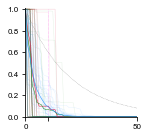

In [50]:
fig, ax = plt.subplots(figsize=figsize, facecolor="white")

# main plot
mortorsurv = "surv"
aging_theory = "pos"
plot_lh(
    df,
    aging_theory,
    "sexual",
    ax,
    lw=0.5,
    plot_bckg=True,
    plot_surv=mortorsurv == "surv",
)
# ax.set_ylim(0.03, 0.07)
# ax.set_yticks([0.03, 0.05, 0.07])
# ax.set_yticklabels([0.03, 0.05, 0.07])

# fig.savefig(
#     plots_dir / f"SUPP-{mortorsurv}-{aging_theory}-sex.{format_}",
#     bbox_inches="tight",
#     **savefig_settings,
# )

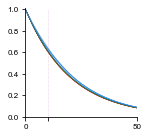

In [67]:
fig, ax = plt.subplots(figsize=figsize, facecolor="white")

# main plot
mortorsurv = "surv"
aging_theory = "pos"
plot_lh(
    df,
    aging_theory,
    "asexual_diploid",
    ax,
    lw=0.5,
    plot_bckg=True,
    plot_surv=mortorsurv == "surv",
)
# ax.set_ylim(0.03, 0.07)
# ax.set_yticks([0.03, 0.05, 0.07])
# ax.set_yticklabels([0.03, 0.05, 0.07])

fig.savefig(
    plots_dir / f"SUPP-{mortorsurv}-{aging_theory}-asex.{format_}",
    bbox_inches="tight",
    **savefig_settings,
)

## Fixation rates

In [128]:
GENOS = {}

for i, yml_path in tqdm.tqdm(enumerate(yml_paths), total=len(yml_paths)):

    # Path to .csv file with phenotypes
    path = yml_path.with_suffix("") / "0/visor/genotypes.csv"
    phenokind, popsize, reprmode, i = yml_path.stem.split("-")

    # # Read configuration
    # with open(yml_path, "r") as file_:
    #     config = yaml.safe_load(file_)
    # popsize = config["MAX_POPULATION_SIZE"]
    # reprmode = config["REPRODUCTION_MODE"]

    # Read in the intrinsic survival rates
    pheno = pd.read_csv(path)
    # print(len(pheno))
    if len(pheno) != 100:
        print([len(pheno), phenokind, popsize, reprmode])
        continue

    # Only look at the last evolved rates
    pheno = pheno.iloc[-1]

    # Save RESULTS
    GENOS[(phenokind, popsize, reprmode, i)] = pheno

  4%|▍         | 16/360 [00:02<00:58,  5.84it/s]


KeyboardInterrupt: 

In [182]:
import yaml


def read_yml(yml_path):
    with open(yml_path, "rb") as file_:
        yml = yaml.safe_load(file_)
    return yml


def get_phenomap_specs(yml):
    return pd.DataFrame(yml["PHENOMAP_SPECS"])


yml = read_yml(yml_paths[0])

In [183]:
(
    pd.DataFrame(yml["PHENOMAP_SPECS"])
    .astype({3: int, 4: float})
    .rename({0: "bittype", 1: "bitpos"}, axis=1)
    .query("bittype == 'neut'")
    .pipe(lambda df: df.iloc[::2].merge(df.iloc[1::2, [1, 3]], on="bitpos"))
)

,bittype,bitpos,2,3_x,4,3_y
0,neut,1,surv,29,0.000390,48
1,neut,2,surv,13,0.001641,21
2,neut,3,surv,20,0.006438,50
3,neut,4,surv,37,0.000254,47
4,neut,5,surv,1,0.003464,3
...,...,...,...,...,...,...
2495,neut,2496,surv,6,0.000194,47
2496,neut,2497,surv,11,0.000311,22
2497,neut,2498,surv,7,0.004301,26
2498,neut,2499,surv,22,0.002332,47


In [186]:
geno = pd.read_csv(yml_paths[0].with_suffix("") / "0/visor/genotypes.csv")

In [226]:
geno.drop([str(_) for _ in range(3)], axis=1).drop([str(_) for _ in range(3)], axis=1)

,3,4,5,6,7,8,9,10,11,12,...,5190,5191,5192,5193,5194,5195,5196,5197,5198,5199
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.009719,0.000000,0.01805,0.000000,0.004859,0.00000,0.000694,0.001041,0.000000,0.000000
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.00000,0.041480,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.01028,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.06595,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,0.000000,0.00000,0.007545,1.000000,0.00000,0.222200,0.000000,0.003772,0.000000
96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,0.000000,0.00000,0.000000,1.000000,0.00000,0.165300,0.000000,0.000000,0.000000
97,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,0.000000,0.00000,0.013440,1.000000,0.01277,0.022850,0.000000,0.005376,0.000000
98,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,0.000000,0.00000,0.000000,1.000000,0.00000,0.000000,0.119000,0.000000,0.008204


In [221]:
geno.drop(range(100), axis=1).drop(range(2500, 2600), axis=1)

KeyError: '[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] not found in axis'

In [181]:
pd.DataFrame(yml["PHENOMAP_SPECS"]).iloc[:-50]

,0,1,2,3,4
0,neut,1,surv,29,0.00038974616994342647
1,neut,1,surv,48,-0.00038974616994342647
2,neut,2,surv,13,0.00164147776206937
3,neut,2,surv,21,-0.00164147776206937
4,neut,3,surv,20,0.006437705073574178
...,...,...,...,...,...
4995,neut,2498,surv,26,-0.0043006289698364715
4996,neut,2499,surv,22,0.0023316574243917
4997,neut,2499,surv,47,-0.0023316574243917
4998,neut,2500,surv,22,0.005274534814686645


In [123]:
genos = pd.DataFrame(GENOS).T.sort_index().droplevel(3, axis=0)

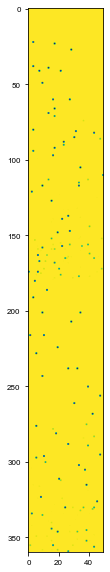

In [126]:
# plt.figure(figsize=(10, 10))
plt.imshow(genos)

# Other

## Plot survivorship

In [198]:
# ax_set_styles_surv = dict(
#     ylim=[0, 1.01],
#     # yticks=[0, 0.05, 0.1],
#     # yticklabels=[0, 0.05, 0.1],
# )


# def plot_surv(df, repr_mode, ax, lw):

#     # plot lines
#     default_survivorship = 0.95 ** np.arange(51)
#     ax.plot(default_survivorship, color="gray", ls="dotted", lw=lw)
#     ax.vlines(10, 0, 1, color="magenta", ls="dotted", alpha=0.5, lw=lw)

#     # calculate data to plot
#     a = df.cumprod(1).loc[aging_theory, :, repr_mode].copy()
#     a.insert(0, "newcol", [1] * len(a), allow_duplicates=True)
#     a = a.T.reset_index(drop=True).T

#     # plot background curves
#     a.T.plot(
#         legend=False,
#         color=plot_colors,
#         ax=ax,
#         alpha=0.1,
#         lw=lw,
#     )

#     # plot mean curve
#     a.reset_index().groupby("index").mean(0).T.plot(
#         ax=ax,
#         color=colors,
#         lw=lw,
#     )

#     # ax.legend(
#     #     handles=patches,
#     #     frameon=False,
#     #     # prop={"size": 4},
#     #     loc=[0.7, 0.015],
#     # )

#     ax.set(**ax_set_styles_general, **ax_set_styles_surv)
#     ax.spines[["right", "top"]].set_visible(False)
#     ax.get_legend().remove()


# for aging_theory in aging_theories:
#     fig, ax = plt.subplots(figsize=figsize)

#     # main plot
#     plot_surv(df, "sexual", ax, lw=0.5)

#     # inset
#     ax = fig.add_axes([0.68, 0.66, 0.2, 0.2])
#     plot_surv(df, "asexual_diploid", ax, lw=0.3)

#     fig.savefig(
#         plots_dir / f"2-surv-{aging_theory}.{format_}",
#         bbox_inches="tight",
#         **savefig_settings,
#     )

In [22]:
# RESULTSx = {}

# for i, yml_path in tqdm.tqdm(enumerate(yml_paths), total=len(yml_paths)):

#     # Path to .csv file with phenotypes
#     path = yml_path.with_suffix("") / "0/visor/phenotypes.csv"
#     phenokind, popsize, reprmode, i = yml_path.stem.split("-")

#     # # Read configuration
#     # with open(yml_path, "r") as file_:
#     #     config = yaml.safe_load(file_)
#     # popsize = config["MAX_POPULATION_SIZE"]
#     # reprmode = config["REPRODUCTION_MODE"]

#     # Read in the intrinsic survival rates
#     pheno = pd.read_csv(path, usecols=range(50))

#     if len(pheno) < 50:
#         print([phenokind, popsize, reprmode])
#         continue

#     # Only look at the last evolved rates
#     pheno = pheno.iloc[50]

#     # Save RESULTS
#     RESULTSx[(phenokind, popsize, reprmode, i)] = pheno

In [53]:
aging_theories = ["pos"]

<AxesSubplot:>

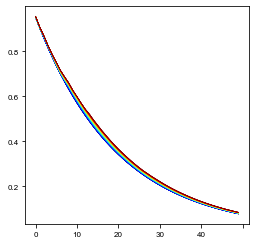

In [116]:
# cont = Container("../experiments/1114/pos-30000-asexual_diploid-101")
cont = Container("../experiments/1114/pos-30000-sexual-158")
# cont = Container("../experiments/1114/pos-3000-sexual-19")
# cont = Container("../experiments/1114/pos-300-sexual-78")
cont.get_df("phenotypes").iloc[:, :50].cumprod(1).T.plot(
    cmap="jet",
    figsize=(4, 4),
    legend=False,
    lw=0.5,
)

<AxesSubplot:>

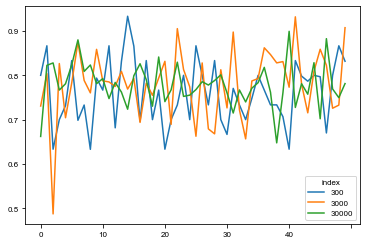

In [82]:
df = pd.DataFrame(RESULTS).T.sort_index().droplevel([0, 3], axis=0)
df.xs("sexual", axis=0, level=1).reset_index().groupby("index").mean().T.plot()

<AxesSubplot:>

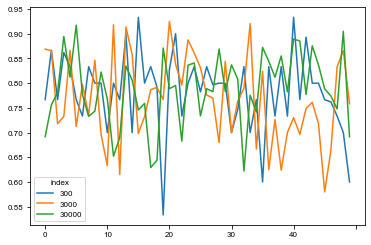

In [84]:
df = pd.DataFrame(RESULTS).T.sort_index().droplevel([0, 3], axis=0)
df.xs("asexual_diploid", axis=0, level=1).reset_index().groupby("index").mean().T.plot()

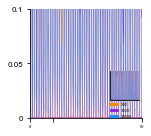

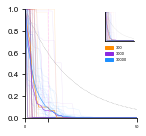

In [54]:
# Transform data into a table

df = pd.DataFrame(RESULTS).T.sort_index().droplevel(3, axis=0)
n_specs_studied = int(len(df) / len(df.index.unique()))

figsize = (2, 2)
dpi = 300

colors = ["darkorange", "blueviolet", "dodgerblue"]
plot_colors = [color for color in colors for _ in range(n_specs_studied)]

patches = [
    # mpatches.Circle(xy=(0, 0), color=colors[0], label="N = 300"),
    # mpatches.Circle(xy=(0, 0), color=colors[1], label="N = 3000"),
    mpatches.Circle(xy=(0, 0), color=colors[0], label="300"),
    mpatches.Circle(xy=(0, 0), color=colors[1], label="3000"),
    mpatches.Circle(xy=(0, 0), color=colors[2], label="30000"),
]

# Plot mortality


for aging_theory in aging_theories:
    fig, ax = plt.subplots(figsize=figsize)
    # plt.hlines(0.05, 0, 51, color="gray", ls="dotted", lw=0.5)
    plt.vlines(10, 0, 1, color="magenta", ls="dotted", alpha=0.5, lw=0.5)
    (
        (1 - df)
        .loc[aging_theory, :, "sexual"]
        .T.plot(
            legend=False,
            color=plot_colors,
            alpha=0.1,
            ax=ax,
            lw=0.5,
        )
    )

    (1 - df.loc[aging_theory, :, "sexual"]).reset_index().groupby("index").mean(
        0
    ).T.plot(
        ax=ax,
        color=colors,
        lw=0.5,
    )
    ax.set_ylim(0, 0.1)
    ax.set_xlim(0, 49)
    ax.set_xticks([0, 10, 49])
    # ax.set_xticklabels([0, "Onset of\nreproduction", 50], fontsize=4)
    ax.set_xticklabels([0, "", 50], fontsize=4)
    ax.set_yticks([0, 0.05, 0.1])
    ax.set_yticklabels([0, 0.05, 0.1])
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    # ax.set_xlabel("Age")
    # ax.set_ylabel("Mortality rate")

    # Legend
    ax.legend(handles=patches, frameon=False, prop={"size": 4}, loc=[0.7, -0.02])

    # Inset
    ax2 = fig.add_axes([0.68, 0.25, 0.2, 0.2])
    # ax2.hlines(0.05, 0, 51, color="gray", ls="dotted", lw=0.2)
    ax2.vlines(10, 0, 1, color="magenta", ls="dotted", alpha=0.5, lw=0.2)

    (
        (1 - df)
        .loc[aging_theory, :, "asexual_diploid"]
        .T.plot(
            legend=False,
            color=plot_colors,
            alpha=0.1,
            ax=ax2,
            lw=0.2,
        )
    )

    (1 - df.loc[aging_theory, :, "asexual_diploid"]).reset_index().groupby(
        "index"
    ).mean(0).T.plot(
        ax=ax2,
        color=colors,
        lw=0.2,
    )
    ax2.set_ylim(0, 0.1)
    ax2.set_xlim(0, 49)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.spines.right.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax2.get_legend().remove()

    # ax2.text(-1, 0.11, "Asexual reproduction", size=3, linespacing=0.9)

    # fig.savefig(plots_dir / f"x2-mort-{aging_theory}.svg", bbox_inches="tight")  # TODO


# Plot Survivorship

default_survivorship = 0.95 ** np.arange(51)

for aging_theory in aging_theories:
    fig, ax = plt.subplots(figsize=figsize)
    ax.vlines(10, 0, 1, color="magenta", ls="dotted", alpha=0.5, lw=0.5)
    ax.plot(default_survivorship, color="gray", ls="dotted", lw=0.5)

    a = df.cumprod(1).loc[aging_theory, :, "sexual"].copy()
    a.insert(0, "newcol", [1] * len(a), allow_duplicates=True)
    a = a.T.reset_index(drop=True).T

    (
        a.T.plot(
            legend=False,
            color=plot_colors,
            ax=ax,
            alpha=0.1,
            lw=0.5,
        )
    )

    a.reset_index().groupby("index").mean(0).T.plot(
        ax=ax,
        color=colors,
        lw=0.5,
    )
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 50)
    ax.set_xticks([0, 10, 50])
    # ax.set_xticklabels([0, "Onset of\nreproduction", 50], fontsize=4)
    ax.set_xticklabels([0, "", 50], fontsize=4)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    # ax.set_xlabel("Age")
    # ax.set_ylabel("Survivorship")

    # Legend
    ax.legend(handles=patches, frameon=False, prop={"size": 4}, loc=[0.7, 0.5])

    # Inset
    ax2 = fig.add_axes([0.68, 0.66, 0.2, 0.2])
    ax2.vlines(10, 0, 1, color="magenta", ls="dotted", alpha=0.5, lw=0.2)
    ax2.plot(default_survivorship, color="gray", ls="dotted", lw=0.2)

    a = df.cumprod(1).loc[aging_theory, :, "asexual_diploid"].copy()
    a.insert(0, "newcol", [1] * len(a), allow_duplicates=True)
    a = a.T.reset_index(drop=True).T

    (
        a.T.plot(
            legend=False,
            color=plot_colors,
            ax=ax2,
            alpha=0.1,
            lw=0.2,
        )
    )

    a.reset_index().groupby("index").mean(0).T.plot(
        ax=ax2,
        color=colors,
        lw=0.2,
    )
    ax2.set_ylim(0, 1)
    ax2.set_xlim(0, 50)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.spines.right.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax2.get_legend().remove()

    # ax2.text(-1, 1.1, "Asexual reproduction", size=3, linespacing=0.9)

    # fig.savefig(plots_dir / f"x2-surv-{aging_theory}.svg", bbox_inches="tight")

# Animate _.yml

In [100]:
dfgeno = pd.read_csv("../temp/_/0/visor/genotypes.csv")

In [101]:
dfanim = pd.read_csv("../temp/_/0/visor/phenotypes.csv")

In [86]:
800 / 32

25.0

In [85]:
xs = np.repeat(range(32), 25)
ys = list(range(25)) * 32

plt.scatter(xs, ys, c=dfgeno.iloc[0], marker="s")

NameError: name 'dfgeno' is not defined

finished


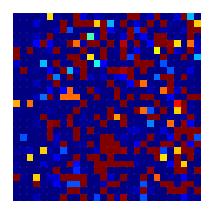

In [139]:
from matplotlib import animation

writer = animation.writers["ffmpeg"](fps=60)
figsize = (3, 3)
fig, ax = plt.subplots(figsize=figsize)


def animate(t):

    plt.cla()
    ax.set(xticks=[], yticks=[])
    data = dfgeno.iloc[t, : 28**2]

    xs = np.repeat(range(28), 28)
    ys = list(range(28)) * 28
    ax.scatter(xs, ys, c=data, marker="s", cmap="jet_r")
    ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
    fig.tight_layout()


import functools

anim = animation.FuncAnimation(fig, animate)
anim.save(
    f"../temp/animate_geno.gif",
    dpi=300,
    writer=animation.PillowWriter(bitrate=300),
)
print("finished")

finished


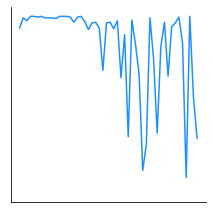

In [142]:
from matplotlib import animation

writer = animation.writers["ffmpeg"](fps=60)
figsize = (3, 3)
fig, ax = plt.subplots(figsize=figsize)


def animate(t):

    plt.cla()
    ax.set(xticks=[], yticks=[], ylim=(0, 1.05))
    data = dfanim.iloc[t, :50]

    ax.plot(data, color="dodgerblue")
    ax.spines[["top", "right"]].set_visible(False)
    fig.tight_layout()


import functools

anim = animation.FuncAnimation(fig, animate)
anim.save(
    f"../temp/animate_pheno.gif",
    dpi=300,
    writer=animation.PillowWriter(bitrate=300),
)
print("finished")

finished


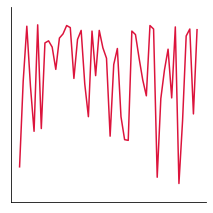

In [141]:
from matplotlib import animation

writer = animation.writers["ffmpeg"](fps=60)
figsize = (3, 3)
fig, ax = plt.subplots(figsize=figsize)


def animate(t):

    plt.cla()
    ax.set(xticks=[], yticks=[], ylim=(0, 0.55))
    data = dfanim.iloc[t, 50:]

    ax.plot(data, color="crimson")
    ax.spines[["top", "right"]].set_visible(False)
    fig.tight_layout()


import functools

anim = animation.FuncAnimation(fig, animate)
anim.save(
    f"../temp/animate_repr.gif",
    dpi=300,
    writer=animation.PillowWriter(bitrate=300),
)
print("finished")

In [ ]:
from matplotlib import animation

writer = animation.writers["ffmpeg"](fps=30)

df = 1 - pd.concat(ANIMRES.values())

figsize = (3, 3)
# dpi = 300

colors = ["crimson", "forestgreen", "dodgerblue"]

patches = [
    mpatches.Circle(xy=(0, 0), color=colors[0], label="N=300"),
    mpatches.Circle(xy=(0, 0), color=colors[1], label="N=3000"),
    mpatches.Circle(xy=(0, 0), color=colors[2], label="N=30000"),
]

fig, ax = plt.subplots(figsize=figsize)

ax_styles = dict(
    xlim=(0, 49),
    xticks=[0, 10, 49],
    xticklabels=([1, "", 50]),
    xlabel="age",
)

ax_styles_mort = dict(
    yticks=[0, 0.05, 0.1],
    yticklabels=[0, 0.05, 0.1],
    ylim=(0, 0.1),
)

ax_styles_surv = dict(
    yticks=[0, 1],
    yticklabels=[0, 1],
    ylim=(0, 1.02),
)


ax.set(**ax_styles)
ax.spines[["top", "right"]].set_visible(False)


def animate(t, aging_theory, data_type):

    plt.cla()
    ax.set(**ax_styles)
    if data_type == "mortality":
        ax.set(**ax_styles_mort)
        ax.hlines(0.05, 0, 51, color="gray", ls="dotted", lw=0.5)
    else:
        ax.set(**ax_styles_surv)
        ax.plot(0.95 ** np.arange(1, 51), color="gray", ls="dotted", lw=0.5)
    ax.set(
        ylabel=data_type,
        title=aging_theory,
        xlabel="age",
    )
    data = (
        df.xs(
            (t, aging_theory, "sexual"),
            level=("t", "phenokind", "reprmode"),
        )
        # .groupby(["popsize"])
        # .mean(0)
    )
    if data_type == "survivorship":
        data = (1 - data).cumprod(1)

    datagr = data.groupby("popsize").mean(0)

    # ax.plot(data.loc["300"].T, color=colors[0], alpha=0.1)
    # ax.plot(data.loc["3000"].T, color=colors[1], alpha=0.1)
    # ax.plot(data.loc["30000"].T, color=colors[2], alpha=0.1)

    ax.plot(datagr.loc["300"], color=colors[0])
    ax.plot(datagr.loc["3000"], color=colors[1])
    ax.plot(datagr.loc["30000"], color=colors[2])
    fig.tight_layout()
    ax.legend(handles=patches, frameon=False, prop={"size": 5.5}, loc=[0.75, 0.2])


import functools

for data_type in ("mortality", "survivorship"):
    print(data_type)
    for aging_theory in ("MA", "AP"):
        print(aging_theory)
        func = functools.partial(
            animate, aging_theory=aging_theory, data_type=data_type
        )
        anim = animation.FuncAnimation(fig, func, interval=100)
        anim.save(
            f"temp/{aging_theory}-{data_type}.gif",
            dpi=300,
            writer=animation.PillowWriter(bitrate=300, fps=10),
        )
print("finished")

# Animations

In [69]:
ANIMRES = {}

for i, yml_path in tqdm.tqdm(enumerate(yml_paths), total=len(yml_paths)):
    path = yml_path.with_suffix("") / "0/visor/phenotypes.csv"
    phenokind, popsize, reprmode, i = yml_path.stem.split("-")
    pheno = pd.read_csv(path, usecols=range(50))
    if len(pheno) < 100:
        print([phenokind, popsize, reprmode])

    multiindex = pd.MultiIndex.from_tuples(
        [(phenokind, popsize, reprmode, i, t) for t in range(len(pheno))],
        names=["phenokind", "popsize", "reprmode", "i", "t"],
    )
    pheno.index = multiindex

    ANIMRES[(phenokind, popsize, reprmode, i)] = pheno

 70%|███████   | 380/540 [00:19<00:07, 22.49it/s]

['pos', '30000', 'sexual']
['pos', '30000', 'sexual']


 71%|███████▏  | 386/540 [00:19<00:07, 21.87it/s]

['pos', '30000', 'sexual']


 73%|███████▎  | 395/540 [00:20<00:06, 21.80it/s]

['pos', '30000', 'sexual']


 74%|███████▍  | 401/540 [00:20<00:06, 21.92it/s]

['pos', '30000', 'sexual']


 76%|███████▋  | 413/540 [00:21<00:05, 21.27it/s]

['pos', '30000', 'sexual']


 78%|███████▊  | 419/540 [00:21<00:05, 23.05it/s]

['pos', '30000', 'sexual']


 79%|███████▉  | 428/540 [00:21<00:04, 23.68it/s]

['pos', '30000', 'sexual']
['pos', '30000', 'sexual']


 82%|████████▏ | 443/540 [00:22<00:04, 21.77it/s]

['pos', '30000', 'sexual']


 83%|████████▎ | 449/540 [00:22<00:04, 21.60it/s]

['pos', '30000', 'sexual']
['pos', '30000', 'sexual']
['pos', '30000', 'sexual']


 85%|████████▍ | 458/540 [00:23<00:03, 22.75it/s]

['pos', '30000', 'sexual']


 87%|████████▋ | 470/540 [00:23<00:03, 19.77it/s]

['pos', '30000', 'sexual']


 88%|████████▊ | 476/540 [00:24<00:02, 21.34it/s]

['pos', '30000', 'sexual']


 91%|█████████▏| 494/540 [00:24<00:02, 22.49it/s]

['pos', '30000', 'sexual']


 95%|█████████▌| 515/540 [00:25<00:01, 22.95it/s]

['pos', '30000', 'sexual']
['pos', '30000', 'sexual']


 98%|█████████▊| 527/540 [00:26<00:00, 22.99it/s]

['pos', '30000', 'sexual']


 99%|█████████▉| 536/540 [00:26<00:00, 24.07it/s]

['pos', '30000', 'sexual']


100%|██████████| 540/540 [00:26<00:00, 20.01it/s]

['pos', '30000', 'sexual']


In [12]:
# pd.concat(ANIMRES.values()).xs(
#     (0, "AP", "sexual"),
#     level=("t", "phenokind", "reprmode"),
# ).groupby(["popsize"]).mean(0).loc["300"]

In [146]:
%matplotlib nbagg

In [147]:
from matplotlib import animation

writer = animation.writers["ffmpeg"](fps=30)

df = 1 - pd.concat(ANIMRES.values())

figsize = (3, 3)
# dpi = 300

colors = ["crimson", "forestgreen", "dodgerblue"]

patches = [
    mpatches.Circle(xy=(0, 0), color=colors[0], label="N=300"),
    mpatches.Circle(xy=(0, 0), color=colors[1], label="N=3000"),
    mpatches.Circle(xy=(0, 0), color=colors[2], label="N=30000"),
]

fig, ax = plt.subplots(figsize=figsize)

ax_styles = dict(
    xlim=(0, 49),
    xticks=[0, 10, 49],
    xticklabels=([1, "", 50]),
    xlabel="age",
)

ax_styles_mort = dict(
    yticks=[0, 0.05, 0.1],
    yticklabels=[0, 0.05, 0.1],
    ylim=(0, 0.1),
)

ax_styles_surv = dict(
    yticks=[0, 1],
    yticklabels=[0, 1],
    ylim=(0, 1.02),
)


ax.set(**ax_styles)
ax.spines[["top", "right"]].set_visible(False)


def animate(t, aging_theory, data_type, reprmode):

    plt.cla()
    ax.set(**ax_styles)
    if data_type == "mortality":
        ax.set(**ax_styles_mort)
        ax.hlines(0.05, 0, 51, color="gray", ls="dotted", lw=0.5)
    else:
        ax.set(**ax_styles_surv)
        ax.plot(0.95 ** np.arange(1, 51), color="gray", ls="dotted", lw=0.5)
    ax.set(
        ylabel=data_type,
        title=aging_theory,
        xlabel="age",
    )
    data = (
        df.xs(
            (t, aging_theory, reprmode),
            level=("t", "phenokind", "reprmode"),
        )
        # .groupby(["popsize"])
        # .mean(0)
    )
    if data_type == "survivorship":
        data = (1 - data).cumprod(1)

    datagr = data.groupby("popsize").mean(0)

    # ax.plot(data.loc["300"].T, color=colors[0], alpha=0.1)
    # ax.plot(data.loc["3000"].T, color=colors[1], alpha=0.1)
    # ax.plot(data.loc["30000"].T, color=colors[2], alpha=0.1)

    ax.plot(datagr.loc["300"], color=colors[0])
    ax.plot(datagr.loc["3000"], color=colors[1])
    ax.plot(datagr.loc["30000"], color=colors[2])
    fig.tight_layout()
    ax.legend(handles=patches, frameon=False, prop={"size": 5.5}, loc=[0.75, 0.2])


import functools

for reprmode in ("asexual_diploid", "sexual"):
    for data_type in ("mortality", "survivorship"):
        print([data_type, reprmode])
        for aging_theory in ("MA", "AP"):
            print(aging_theory)
            func = functools.partial(
                animate,
                aging_theory=aging_theory,
                data_type=data_type,
                reprmode=reprmode,
            )
            anim = animation.FuncAnimation(fig, func, interval=100)
            anim.save(
                f"temp/{aging_theory}-{data_type}-{reprmode}.gif",
                dpi=300,
                writer=animation.PillowWriter(bitrate=300, fps=10),
            )
print("finished")

<IPython.core.display.Javascript object>

['mortality', 'asexual_diploid']
MA
AP
['survivorship', 'asexual_diploid']
MA
AP
['mortality', 'sexual']
MA
AP
['survivorship', 'sexual']
MA
AP
finished


# Generation time

In [126]:
gentimes = []

for i, yml_path in tqdm.tqdm(enumerate(yml_paths), total=len(yml_paths)):

    # Path to .csv file with phenotypes
    path = yml_path.with_suffix("") / "0/snapshots/demography/1000000.feather"
    feather = pd.read_feather(path)
    mean_age = feather.query("ages >= 10").ages.mean()

    gentimes.append(yml_path.stem.split("-") + [mean_age])

100%|██████████| 240/240 [00:02<00:00, 84.77it/s]


In [129]:
df = pd.DataFrame(gentimes)
df.columns = ["maap", "popsize", "reprmode", "id", "meanage"]

In [150]:
# df.groupby(["maap", "popsize", "reprmode"]).media

<AxesSubplot:ylabel='Frequency'>

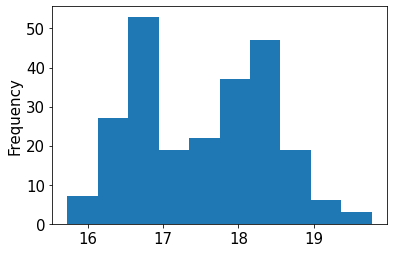

In [159]:
df.meanage.plot.hist()

(array([1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(1, 0, '(AP, 300, asexual_diploid)'),
  Text(2, 0, '(AP, 300, sexual)'),
  Text(3, 0, '(AP, 3000, asexual_diploid)'),
  Text(4, 0, '(AP, 3000, sexual)'),
  Text(5, 0, '(MA, 300, asexual_diploid)'),
  Text(6, 0, '(MA, 300, sexual)'),
  Text(7, 0, '(MA, 3000, asexual_diploid)'),
  Text(8, 0, '(MA, 3000, sexual)')])

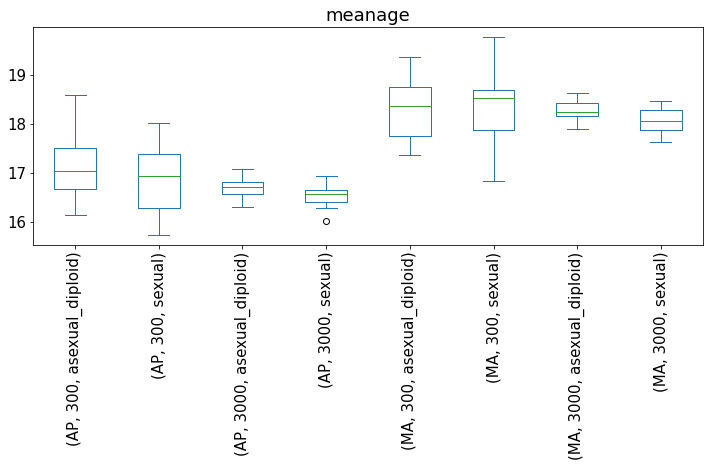

In [156]:
matplotlib.rcParams.update({"font.size": 15})
df.plot.box(by=["maap", "popsize", "reprmode"], figsize=(12, 4))
plt.xticks(rotation=90)

In [162]:
df.meanage.mean(), df.meanage.median()

(17.524274187172992, 17.63188118811881)

# X. Other plots

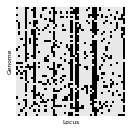

In [22]:
# Random genomes
rng = np.random.default_rng(42)

genomes = np.repeat((rng.random(50) < 0.2).astype(int), 50).reshape(50, 50).T
genomes = np.logical_xor(genomes, rng.random(size=(50, 50)) < 0.15).astype(int)

fig, ax = plt.subplots(figsize=(2, 2))
plt.imshow(genomes, vmin=-0.1, vmax=1, cmap="binary", interpolation="nearest")
ax.set_xlim(-0.5, 50 - 0.5)
ax.set_ylim(-0.5, 50 - 0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("Locus")
ax.set_ylabel("Genome")
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
fig.savefig(plots_dir / "1-genomes.svg", bbox_inches="tight")

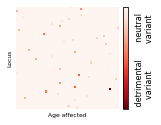

In [89]:
# for MA
phenomap_path = pathlib.Path("../experiments/0815/MA-3000-sexual-1/0/phenomap.csv")
phenomap = pd.read_csv(phenomap_path, header=None)

data = phenomap.iloc[
    100:150, :50
]  # Take first 50 neut loci that encode for the life history traits because of the phenomap
data[data == 0.95] = 0  # Ignore identity effects

# Main plot
fig, ax = plt.subplots(figsize=(2, 2))
im = plt.imshow(
    data,
    cmap="Reds_r",
    vmin=data.min().min(),
    vmax=data.max().max(),
    interpolation="nearest",
)
plt.xlim(-0.5, 49.5)
plt.ylim(-0.5, 49.5)
plt.xticks([])
plt.yticks([])
plt.xlabel("Age affected")
plt.ylabel("Locus")

# Colorbar
cbar = plt.colorbar(im, fraction=0.0455, pad=0.04)
cbar.ax.set_yticklabels([])
cbar.ax.set_yticks([])
cbar.set_label(
    " detrimental       neutral\n    variant           variant",
    rotation=90,
    size=8,
    labelpad=7,
    ha="left",
    y=0,
)

# Despine
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)

# Save
fig.savefig(plots_dir / "1-MA-map.svg", bbox_inches="tight")

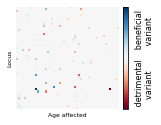

In [88]:
# for AP
phenomap_path = pathlib.Path("../experiments/0815/AP-3000-sexual-5/0/phenomap.csv")
phenomap = pd.read_csv(phenomap_path, header=None)

data = phenomap.iloc[
    100:150, :50
]  # Take first 50 neut loci that encode for the life history traits because of the phenomap
data[data == 0.95] = 0  # Ignore identity effects

# Main plot
fig, ax = plt.subplots(figsize=(2, 2))
im = plt.imshow(
    data,
    cmap="RdBu",
    vmin=data.min().min() * 0.9,
    vmax=data.max().max() * 0.9,
    interpolation="nearest",
)
plt.xlim(-0.5, 49.5)
plt.ylim(-0.5, 49.5)
plt.xticks([])
plt.yticks([])
plt.xlabel("Age affected")
plt.ylabel("Locus")

# Colorbar
cbar = plt.colorbar(im, fraction=0.0455, pad=0.04)
cbar.ax.set_yticklabels([])
cbar.ax.set_yticks([])
# cbar.set_label("detrimental ... beneficial", rotation=90, size=8, labelpad=7)
cbar.set_label(
    " detrimental    beneficial\n    variant          variant",
    rotation=90,
    size=8,
    labelpad=7,
    ha="left",
    y=0,
)

# Despine
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)

# Save
fig.savefig(plots_dir / "1-AP-map.svg", bbox_inches="tight")

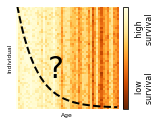

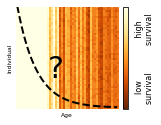

In [126]:
pickle_paths = [
    pathlib.Path("../experiments/0815/MA-3000-sexual-1/0/pickles/1000000"),
    pathlib.Path("../experiments/0815/AP-3000-sexual-5/0/pickles/1000000"),
]

rng = np.random.default_rng(42)

for pickle_path in pickle_paths:

    with open(pickle_path, "rb") as file_:
        pickle_ = pickle.load(file_)

    phenokind = "MA" if "MA" in str(pickle_path) else "AP"

    fig, ax = plt.subplots(figsize=(2, 2))
    phenos = pickle_.phenotypes.copy().reshape(
        pickle_.genomes.shape[0], pickle_.genomes.shape[2]
    )
    phenos[:, 0] = 1

    noise = rng.random(size=[50, 50]) * 0.01
    mask = rng.random(size=noise.shape) < 0.5
    noise[mask] = 0
    phenosplot = (phenos[:50, :50] - noise) ** 1.6

    vmin = 0.8 if phenokind == "AP" else 0.82
    vmax = 0.97 if phenokind == "AP" else 0.92

    im = plt.imshow(
        phenosplot, cmap="YlOrBr_r", vmin=vmin, vmax=vmax, interpolation="nearest"
    )
    plt.xlim(-0.5, 49.5)
    plt.ylim(-0.5, 49.5)
    plt.xticks([])
    plt.yticks([])
    # plt.title("age-dep survival rate")
    plt.xlabel("Age")
    plt.ylabel("Individual")

    # Plot overlay
    plt.plot(50 * 0.9 ** np.arange(50), c="black", alpha=1, lw=2, ls="--")
    ax.text(15, 15, "?", size=30)

    # Colorbar
    cbar = plt.colorbar(im, fraction=0.0455, pad=0.04)
    cbar.ax.set_yticklabels([])
    cbar.ax.set_yticks([])
    # cbar.set_label("low ... high", rotation=90, size=8, labelpad=7)
    cbar.set_label(
        "      low                 high\n  survival           survival",
        rotation=90,
        size=8,
        labelpad=7,
        ha="left",
        y=0,
    )

    # Despine
    ax.spines.right.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)

    fig.savefig(plots_dir / f"1-{phenokind}-pheno.svg", bbox_inches="tight")